##Project 2: Data Representations and Clustering

Contributors:
1. Rachel Menezes (905508013)

2. bb

3. cc

###Part 1 - Clustering on Text Data

####Clustering with Sparse Text Representations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/Data-Representations-and-Clustering

/content/drive/MyDrive/Github/Data-Representations-and-Clustering


In [4]:
# !git pull
!git config --global user.email "menezesrachel31@gmail.com"
!git config --global user.name "R"
! git commit -am "Question 1-9 first run"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@bc88755f1aa7.(none)')


In [3]:
# "Import statements"
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD, NMF
from plotmat import plot_mat

In [4]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)

In [5]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers'), random_state=random_state)

In [6]:
print("Unique data target names: ",newsgroups_data.target_names)
print("Unique data targets: ",np.unique(newsgroups_data.target))

Unique data target names:  ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
Unique data targets:  [0 1 2 3 4 5 6 7]


In [7]:
# Functions needed
def convert_labels(train_dataset):
    """ Function to merge classes together and convert the problem into a binary classification problem """
    labels = []
    
    for label in train_dataset.target:
        name = train_dataset.target_names[label]
        if name.startswith('comp'):
            labels.append(0)
        elif name.startswith('rec'):
            labels.append(1)
        else:
            print('Wrong type: ', label)
    return labels

def print_clustering_measures(true_labels, pred_labels):
  homogeneity = homogeneity_score(true_labels, pred_labels)
  completeness = completeness_score(true_labels, pred_labels)
  v_measure = v_measure_score(true_labels, pred_labels)
  ari = adjusted_rand_score(true_labels, pred_labels)
  ami = adjusted_mutual_info_score(true_labels, pred_labels)

  # Print the 5 clustering measures
  print("\nClustering Measures:")
  print(f"* Homogeneity: {homogeneity:.3f}")
  print(f"* Completeness: {completeness:.3f}")
  print(f"* V-Measure: {v_measure:.3f}")
  print(f"* Adjusted Rand Index: {ari:.3f}")
  print(f"* Adjusted Mutual Information: {ami:.3f}")
  print()

In [8]:
vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(newsgroups_data.data)

In [9]:
rows, columns = tfidf_matrix.shape
print(f"The TF-IDF matrix has {rows} rows (documents) and {columns} columns (features/words).")

The TF-IDF matrix has 7882 rows (documents) and 23522 columns (features/words).


In [10]:
true_labels = convert_labels(newsgroups_data)
print("Computer Technology maps to 0 and Recreational Activity to 1")

Computer Technology maps to 0 and Recreational Activity to 1


**QUESTION 1:** Report the dimensions of the TF-IDF matrix you obtain.

**Ans** The TF-IDF matrix has 7882 rows (documents) and 23522 columns (features/words).

In [11]:
kmeans = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
kmeans.fit(tfidf_matrix)
pred_labels = kmeans.predict(tfidf_matrix)

In [12]:
contingency_table = contingency_matrix(true_labels, pred_labels)

Contingency Table:


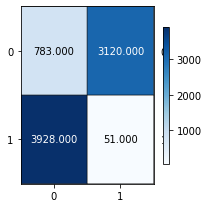

In [13]:
# Print the contingency table
print("Contingency Table:")
plot_mat(contingency_table, size=(3,3))

In [14]:
print_clustering_measures(true_labels, pred_labels)


Clustering Measures:
* Homogeneity: 0.564
* Completeness: 0.580
* V-Measure: 0.572
* Adjusted Rand Index: 0.621
* Adjusted Mutual Information: 0.572



**QUESTION 2:** Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?

**Ans** The contingency table is reported above. The contingency table does not have to be square-shaped. The shape depends on the number of unique class labels and the number of unique predicted cluster labels. If there are n unique class labels and m unique predicted cluster labels, the contingency table will have n rows and m columns and if n ≠ m, the contingency table will be rectangular.

**QUESTION 3:** Report the 5 clustering measures explained in the introduction for Kmeans clustering.

**Ans** 
Clustering Measures:
* Homogeneity: 0.564
* Completeness: 0.580
* V-Measure: 0.572
* Adjusted Rand Index: 0.621
* Adjusted Mutual Information: 0.572

#### Clustering with Dense Text Representations

In [15]:
# Apply Truncated SVD to the TF-IDF matrix
svd = TruncatedSVD(n_components=1000)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [16]:
# Compute the explained variance ratio for each component
explained_variance_ratio = svd.explained_variance_ratio_
ratio = svd.explained_variance_ratio_.cumsum()

Text(0, 0.5, 'Percentage of Variance')

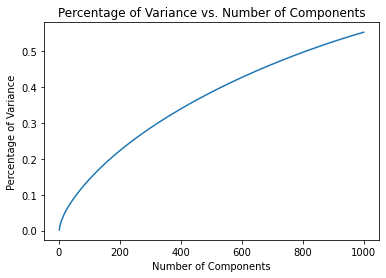

In [18]:
# Make a plot
plt.plot(range(1, 1001), ratio)
plt.title('Percentage of Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance')

**QUESTION 4:** Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

**Ans** Plot is reported above.

In [19]:
# Perform SVD
ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
hs_svd, cs_svd, vs_svd, ars_svd, ams_svd = [], [], [], [], []

for r in ranks:
    # Apply SVD
    svd = TruncatedSVD(n_components=r)
    reduced_data = svd.fit_transform(tfidf_matrix)
    
    kmeans_svd = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
    y_pred = kmeans_svd.fit_predict(reduced_data)
    
    hs_svd.append(homogeneity_score(true_labels, y_pred))
    cs_svd.append(completeness_score(true_labels, y_pred))
    vs_svd.append(v_measure_score(true_labels, y_pred))
    ars_svd.append(adjusted_rand_score(true_labels, y_pred))
    ams_svd.append(adjusted_mutual_info_score(true_labels, y_pred))

In [20]:
def plot_dense_scores(ranks, hs, cs, vs, ars, ams, title):  
  plt.plot(ranks, hs, label = "Homogeneity")
  plt.plot(ranks, cs, label = "Completeness")
  plt.plot(ranks, vs, label = "V-measure")
  plt.plot(ranks, ars, label = "Adjusted Rand Index")
  plt.plot(ranks, ams, label = "Adjusted Mutual Information")
  plt.title(title)
  plt.xlabel("r (number of principal components)")
  plt.ylabel("Scores")
  plt.legend()

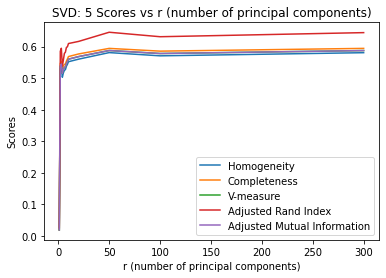

In [21]:
plot_dense_scores(ranks, hs_svd, cs_svd, vs_svd, ars_svd, ams_svd, "SVD: 5 Scores vs r (number of principal components)")

In [22]:
ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
hs_nmf, cs_nmf, vs_nmf, ars_nmf, ams_nmf = [], [], [], [], []
for r in ranks:
    # Apply NMF
    nmf = NMF(n_components=r)
    reduced_data = nmf.fit_transform(tfidf_matrix)
    kmeans_nmf = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
    y_pred = kmeans_nmf.fit_predict(reduced_data)
    
    hs_nmf.append(homogeneity_score(true_labels, y_pred))
    cs_nmf.append(completeness_score(true_labels, y_pred))
    vs_nmf.append(v_measure_score(true_labels, y_pred))
    ars_nmf.append(adjusted_rand_score(true_labels, y_pred))
    ams_nmf.append(adjusted_mutual_info_score(true_labels, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed fro

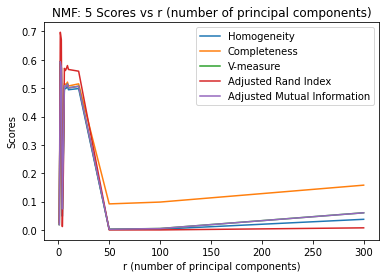

In [23]:
plot_dense_scores(ranks, hs_nmf, cs_nmf, vs_nmf, ars_nmf, ams_nmf, "NMF: 5 Scores vs r (number of principal components)")

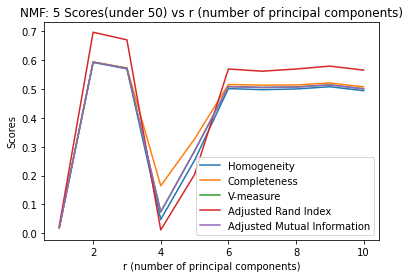

In [29]:
# Make a plot by keeping r within 10 to identify best r
plot_dense_scores(ranks[:10], hs_nmf[:10], cs_nmf[:10], vs_nmf[:10], ars_nmf[:10], ams_nmf[:10], "NMF: 5 Scores(under 10) vs r (number of principal components)")

**QUESTION 5:** Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF. Report a good choice of r for SVD and NMF respectively. Note: In the choice of r, there is a trade-off between the information preservation, and better performance of k-means in lower dimensions.

**Ans.** From the graph for SVD: 5 Scores vs r (number of principal components), the best choice for r is 300. Although, the graph seems to increase, if we increase r beyond 300, then it would increase till a particular point and then fall down.

From the graph for NMF: 5 Scores vs r (number of principal components), the best choice for r is 2.

**QUESTION 6:** How do you explain the non-monotonic behavior of the measures as r increases?

**Ans.** A non-monotic behaviour is observed in the graphs as r increases. The scores first increase, then fall and plateau off in the end as r increases. As the number of components increase, the dimensions from which k-means needs to perform clustering increases and k-means suffers due to the well known curse of dimensionality. It makes it difficult to cluster points as the eucledian distance is no longer a good metric becasue the ratio of eucledian distances between nearest and farthest point from the cluster center approaches 1. Thus, increasing the number of features beyond the elbow point does not add new information in the clustering task and the measures reamin constant and eventually plateau.

**QUESTION 7:** Are these measures on average better than those computed in Question 3?

**Ans.** The results without data compression and after data compression using SVD and NMF with n_components as 300 and 2 respectively are nearly the same as

The observed trend has been summarized in the following points:

- The results of SVD are unique. The results of NMF are non-unique as it uses stochastic algorithm for convergence.

- SVD has no restrictions on the data entries whereas in the case of NMF only positive entires are allowed in the reduced rank feature matrix. Thus, SVD is able to better represent the feature matrix as compared to NMF and the information loss is less in SVD. The results of SVD are more predictable when compared to NMF because the results are ordered by relevance in a geometric basis. Geometry is not considered by NMF in the feature space basis. Also, in SVD, increasing the value of r does not cause significant change in the scores because the most relevant features that are higher in the hierarchy are used in forming the feature matrix.

- In the graph of scores vs number of principle components for SVD, the scores saturate for r in the range 20 to 300. For NMF, the scores peak at r = 2.

Thus, the results of SVD are near about the same and the results of NMF are worse.

###Part 2 - Visualize the clusters


Clustering Measures:
* Homogeneity: 0.574
* Completeness: 0.589
* V-Measure: 0.582
* Adjusted Rand Index: 0.635
* Adjusted Mutual Information: 0.581



Text(0.5, 1.0, 'Predicted cluster (SVD)')

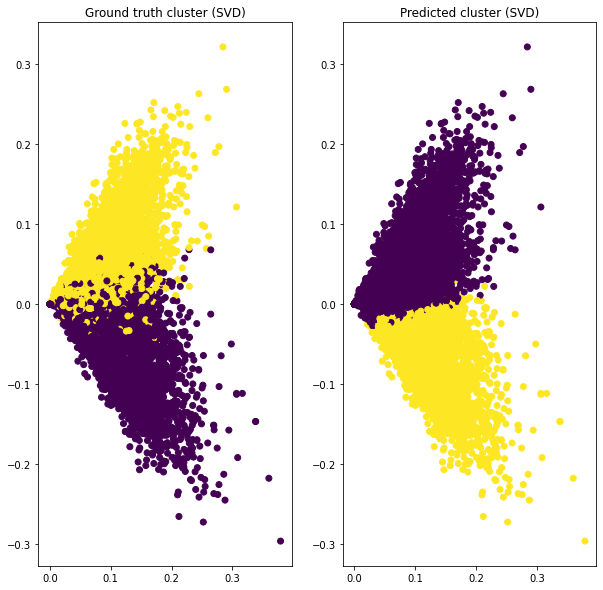

In [25]:
# SVD (300)
svd = TruncatedSVD(n_components=300)
data_svd_300 = svd.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 10))

kmeans_model = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
y_pred = kmeans_model.fit_predict(data_svd_300)

print_clustering_measures(true_labels, y_pred)

plt.subplot(121)
plt.scatter(data_svd_300[:, 0], data_svd_300[:, 1], c=true_labels)
plt.title("Ground truth cluster (SVD)")

plt.subplot(122)
plt.scatter(data_svd_300[:, 0], data_svd_300[:, 1], c=y_pred)
plt.title("Predicted cluster (SVD)")

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Clustering Measures:
* Homogeneity: 0.593
* Completeness: 0.594
* V-Measure: 0.594
* Adjusted Rand Index: 0.697
* Adjusted Mutual Information: 0.594



Text(0.5, 1.0, 'Predicted cluster (NMF)')

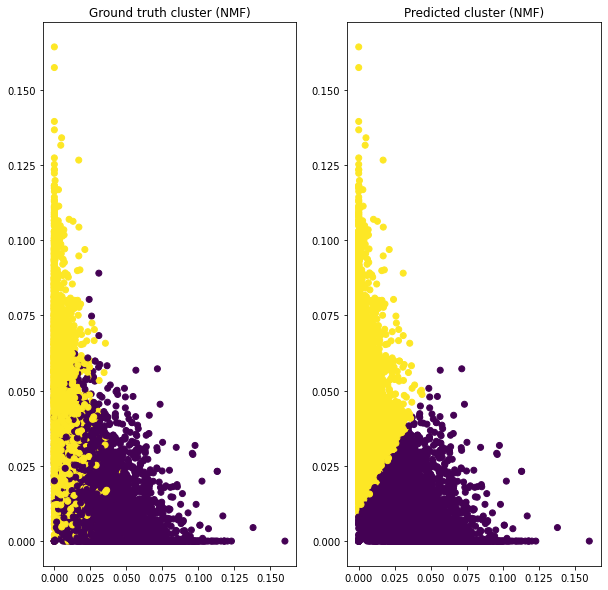

In [26]:
# NMF(2)
nmf = NMF(n_components=2)
data_nmf_2 = nmf.fit_transform(tfidf_matrix)
plt.figure(figsize=(10, 10))

# Train a k-means model
kmeans_model = KMeans(n_clusters=2, random_state=random_state, max_iter=1000, n_init=30)
y_pred = kmeans_model.fit_predict(data_nmf_2)

print_clustering_measures(true_labels, y_pred)

plt.subplot(121)
plt.scatter(data_nmf_2[:, 0], data_nmf_2[:, 1], c=true_labels)
plt.title("Ground truth cluster (NMF)")

plt.subplot(122)
plt.scatter(data_nmf_2[:, 0], data_nmf_2[:, 1], c=y_pred)
plt.title("Predicted cluster (NMF)")

**QUESTION 8:**  Visualize the clustering results for:
- SVD with your optimal choice of r for K-Means clustering;
- NMF with your choice of r for K-Means clustering.

**Ans** The 2 graphs are shown in the above cells.

**QUESTION 9:**  What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

**Ans** In both the visualizations, the data is linearly separable & the k-means model performs well on the given data. Yes the distrbution is ideal for k-means clustering.